In [1]:
import open3d as o3d
import sys
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import imageio
from tqdm import tqdm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Save points and normals

In [2]:
# path = "../ros_ws/src/gradslam_ros/data/explorer_x1_rgbd_traj/living_room_traj1_frei_png/"

# rgb_files = [f for f in os.listdir(os.path.join(path, 'rgb')) if '.png' in f]
# color_img = imageio.imread(path+f"rgb/{0}.png")

# K = np.load(path+f"caminfo/{0}.npy")
# intrinsics = o3d.camera.PinholeCameraIntrinsic(width=color_img.shape[0], height=color_img.shape[1],
#                                                fx=K[0, 0], fy=K[1, 1], cx=K[0, 2], cy=K[1, 2])

# for ind in tqdm(range(len(rgb_files))):
# #     color_raw = o3d.io.read_image(path+f"rgb/{ind}.png")
#     depth_raw = o3d.io.read_image(path+f"depth/{ind}.png")
# #     rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw)
# #     pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, intrinsics)
#     pcd = o3d.geometry.PointCloud.create_from_depth_image(depth_raw, intrinsics)
#     pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

#     # Open3D can be used to estimate point cloud normals with `estimate_normals`,
#     # which locally fits a plane per 3D point to derive the normal.
#     pcd.estimate_normals()

#     # However, the estimated normals might not be consistently oriented.
#     # `orient_normals_consistent_tangent_plane` propagates the normal orientation using a minimum spanning tree.
#     pcd.orient_normals_consistent_tangent_plane(k=15)
    
#     # save points and normals
#     np.save(os.path.join(path, f'point_clouds/{ind}.npy'), np.asarray(pcd.points))
#     np.save(os.path.join(path, f'normals/{ind}.npy'), np.asarray(pcd.normals))

### Depth correction

In [3]:
import torch
import torch.nn as nn


class Model(nn.Module):

    def __init__(self, batch_size=1):
        super(Model, self).__init__()
        self.w = nn.Parameter(torch.rand(batch_size, 1, 2))
        self.b = nn.Parameter(torch.rand(batch_size, 1))

    def forward(self, x):
        assert x.dim() == 4
        assert x.shape[3] == 2  # x.shape == (B, H, W, 2)
        y = (x * self.w).sum(dim=3) + self.b
        return y

In [4]:
from torch.utils.data import Dataset, DataLoader


class Dataset(Dataset):
    def __init__(self, path):
        if not os.path.exists(path):
            os.makedirs(path)
        self.root_dir = path
        self.rgbs = [os.path.join(path, 'rgb', f) for f in os.listdir(os.path.join(path, 'rgb')) if '.npy' in f]
        self.depths = [os.path.join(path, 'depth', f) for f in os.listdir(os.path.join(path, 'depth')) if '.npy' in f]
        self.points = [os.path.join(path, 'point_clouds', f) for f in os.listdir(os.path.join(path, 'point_clouds')) if '.npy' in f]
        self.normals = [os.path.join(path, 'normals', f) for f in os.listdir(os.path.join(path, 'normals')) if '.npy' in f]
        self.length = len(self.depths)

    def __getitem__(self, i):
        sample = {'rgb': np.asarray(np.load(self.rgbs[i]), dtype=np.uint8),
                  'depth': np.load(self.depths[i]),
                  'points': np.load(self.points[i]),
                  'normals': np.load(self.normals[i])}
        return sample

    def __len__(self):
        return self.length

In [5]:
path = "../ros_ws/src/gradslam_ros/data/explorer_x1_rgbd_traj/living_room_traj1_frei_png/"

data = Dataset(path)
loader = DataLoader(data)

model = Model()

tensor(5035.2568, grad_fn=<MeanBackward0>)


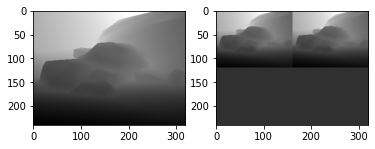

tensor(111.2759, grad_fn=<MeanBackward0>)


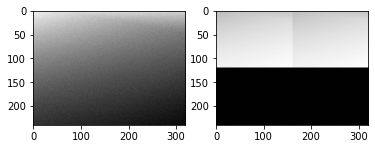

tensor(11841.0410, grad_fn=<MeanBackward0>)


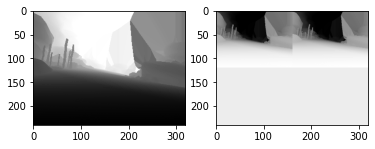

tensor(4192.1621, grad_fn=<MeanBackward0>)


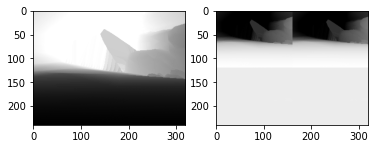

tensor(15621.0352, grad_fn=<MeanBackward0>)


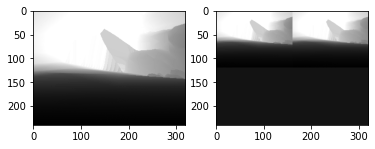

tensor(12583.6094, grad_fn=<MeanBackward0>)


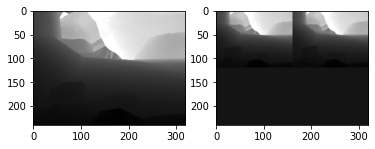

In [9]:
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
optim.zero_grad()

for i, sample in enumerate(iter(loader)):
    B, H, W = sample['depth'].shape
    normals = torch.as_tensor(sample['normals'], dtype=torch.float32)
    depth = torch.as_tensor(sample['depth'], dtype=torch.float32)
    assert normals.shape == (B, W*H, 3)
    
    # convert normals to angles
    n = normals / torch.linalg.norm(normals)
    
    angles = torch.empty(B, H, W)
    for b in range(B):
        n1 = n[b, ...]
        # normal vector to image frame
        v = torch.tensor([0., 0., 1.], dtype=torch.float32)
        angles1 = torch.arccos(torch.clip(n1 @ v, -1.0, 1.0))
        angles[b, ...] = angles1.reshape([H, W])
    assert angles.shape == (B, H, W)
    
    # input to the model
    x = torch.cat([depth, angles], dim=0).reshape([B, H, W, 2])
    
    # inference
    depth_pred = model(x)
    assert depth_pred.shape == (B, H, W)
    assert depth.shape == (B, H, W)
    
    loss = torch.mean(torch.abs(depth - depth_pred))
    loss.backward()
    optim.step()
    
    if i % 100 == 0:
        print("Loss:", loss.item())
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(depth[0], cmap='gray')
        plt.subplot(1, 2, 2)
        plt.imshow(depth_pred[0].detach(), cmap='gray')
        plt.show()
